In [1]:
import pandas as pd
import numpy as np
import re
import copy
from collections import Counter
import string
import sys
from scipy.sparse import hstack
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline

In [2]:
pd.set_option('max_colwidth', None)

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize.treebank import TreebankWordDetokenizer
from nltk.corpus import stopwords
import contractions

from nltk import word_tokenize, TweetTokenizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer

import emoji as emj
import spacy 
## It's important to use _lg for OOV in future
nlp = spacy.load('en_core_web_lg')

In [5]:
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.compose import ColumnTransformer
from sklearn.metrics import f1_score, accuracy_score

In [6]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

In [7]:
import pickle
from joblib import dump

In [8]:
df_train = pd.read_csv("../data/train.csv")
df_test = pd.read_csv("../data/test.csv")

In [9]:
nltk.download()
STOPWORDS = set(stopwords.words('english'))

showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


In [10]:
wnl = WordNetLemmatizer()

# Exploratory Data Analysis

In [11]:
df_train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation orders in California",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,1


In [12]:
df_train.isnull().mean()

id          0.000000
keyword     0.008013
location    0.332720
text        0.000000
target      0.000000
dtype: float64

In [13]:
df_train.shape, df_test.shape

((7613, 5), (3263, 4))

In [14]:
#cardinality check
for col in df_train.columns:
    print('{} has {} unique instances'.format(col, len(df_train[col].unique())))

id has 7613 unique instances
keyword has 222 unique instances
location has 3342 unique instances
text has 7503 unique instances
target has 2 unique instances


In [15]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


## Keyword Analysis

In [16]:
df_train.keyword.value_counts()

fatalities               45
deluge                   42
armageddon               42
sinking                  41
damage                   41
                         ..
forest%20fire            19
epicentre                12
threat                   11
inundation               10
radiation%20emergency     9
Name: keyword, Length: 221, dtype: int64

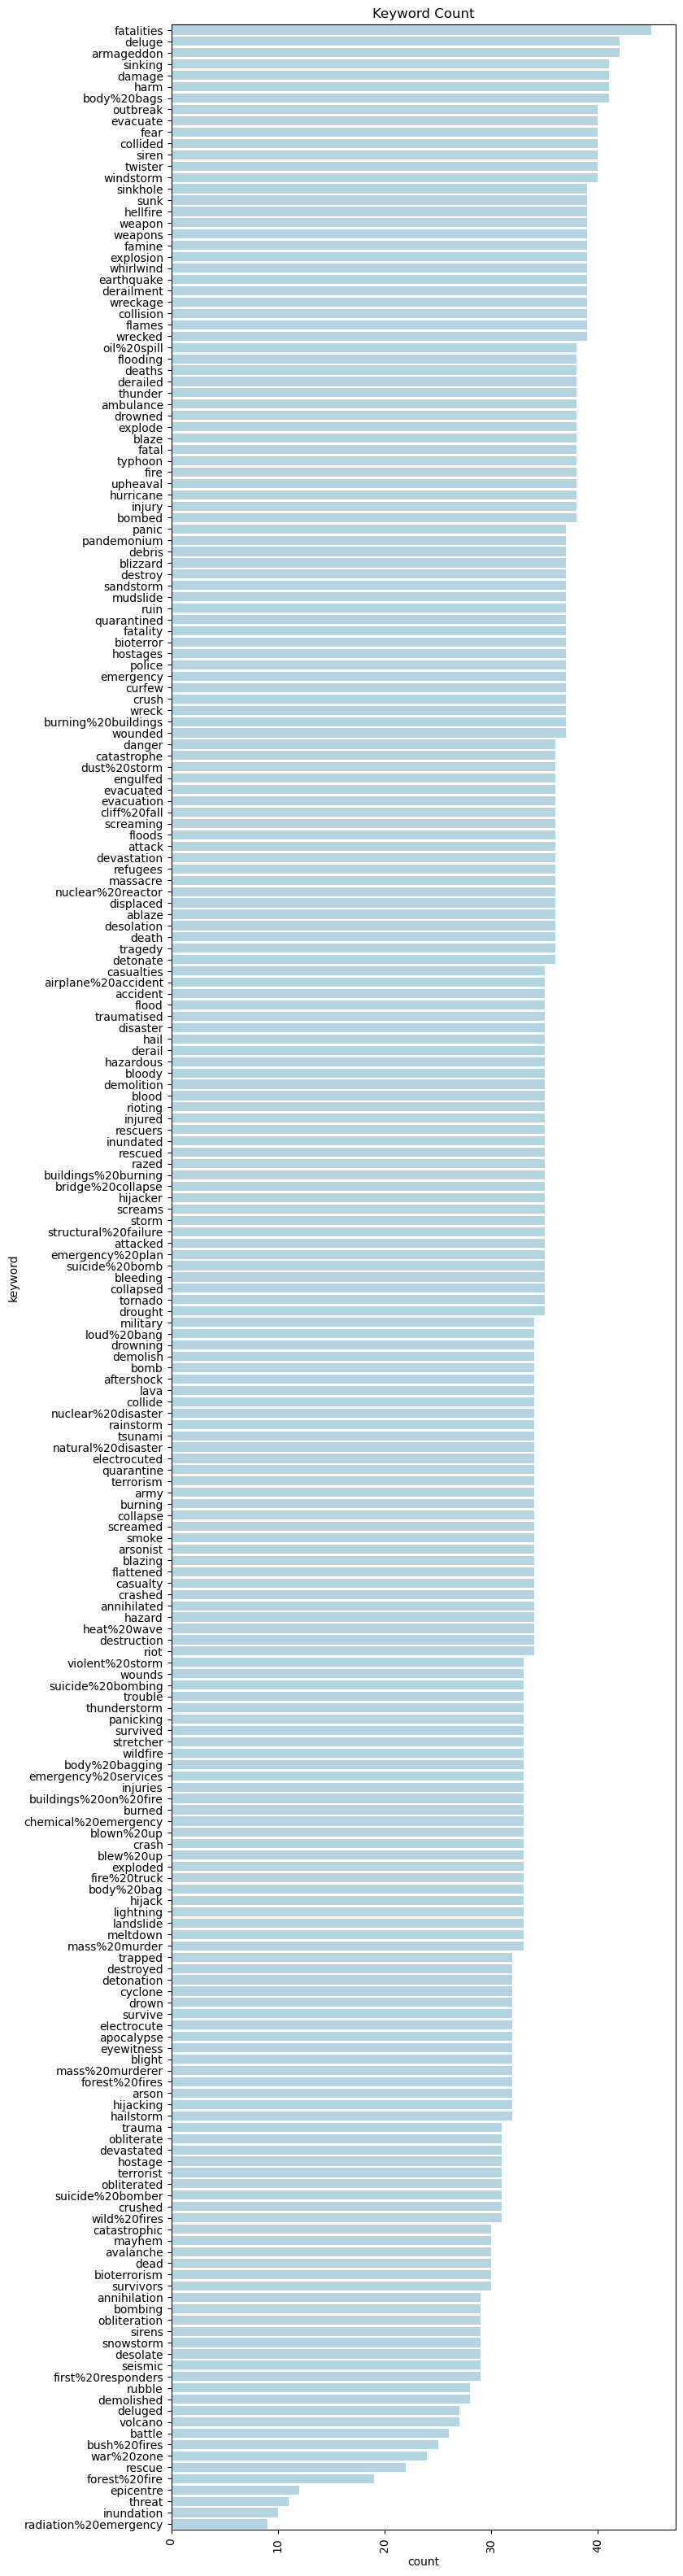

In [17]:
plt.figure(figsize=[8, 40])
sns.countplot(y='keyword',
              data=df_train,
              color='lightblue',
              order=df_train['keyword'].value_counts().index)
plt.xticks(rotation=90)
plt.title("Keyword Count")
plt.show()

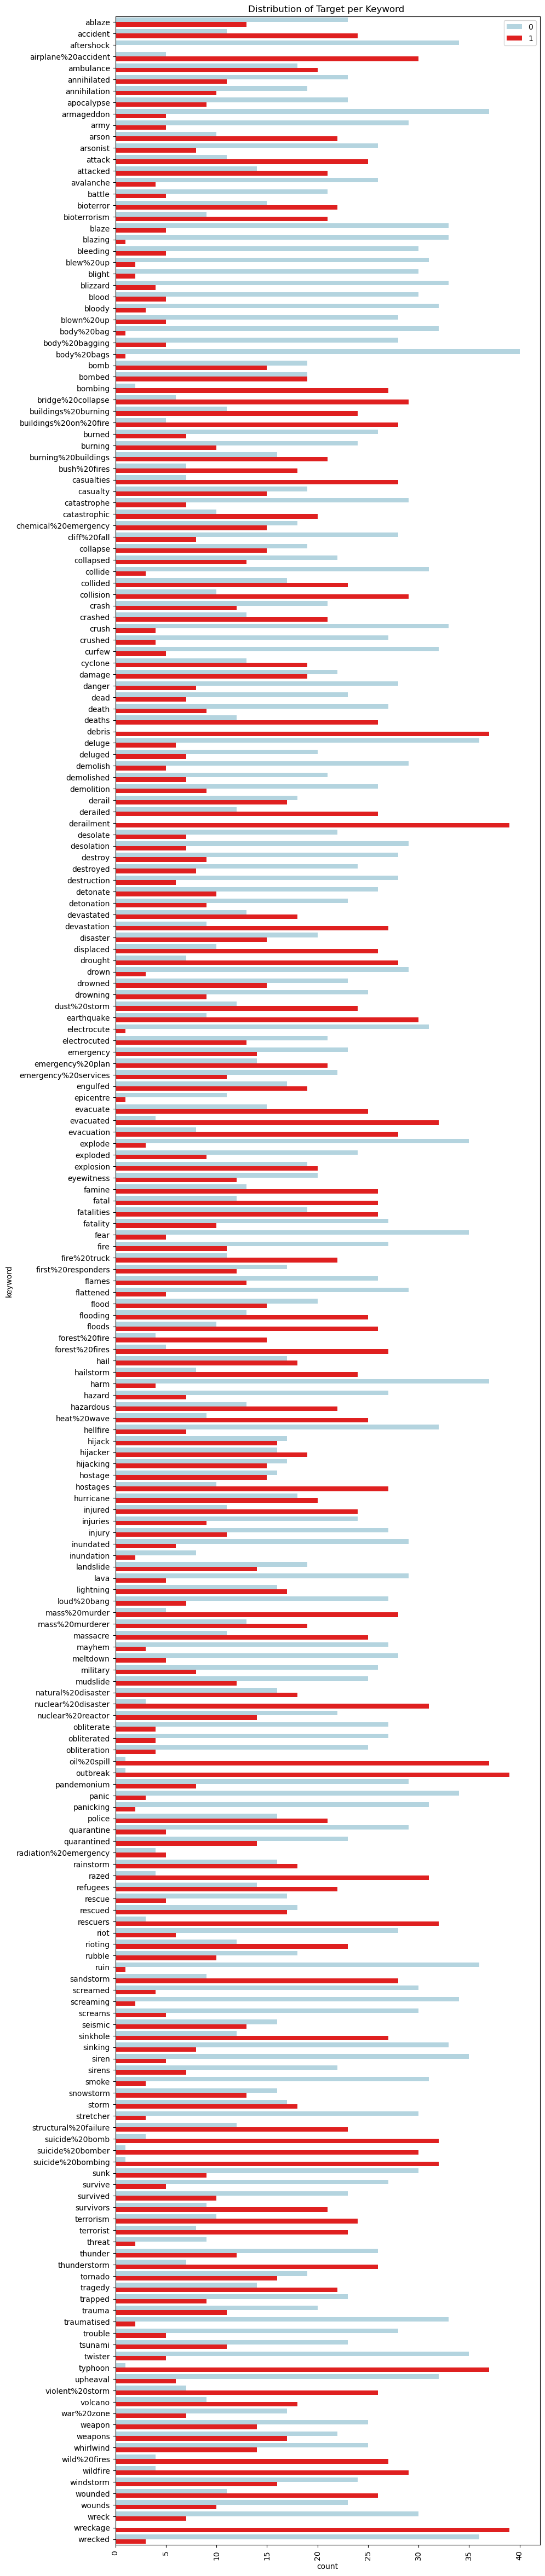

In [18]:
plt.figure(figsize=[10, 60])
sns.countplot(y='keyword', 
              hue='target', 
              data=df_train, 
              palette=['lightblue', 'red']
             )
plt.xticks(rotation=90)
plt.legend(loc='upper right')
plt.title("Distribution of Target per Keyword ")
plt.show()

Substring "%20" in keywords looks a little bit strange, so I want to replace it with ' '. The graph above shows that for many keywords the target has a very clear distribution, for example for . Let's show the distribution for each keyword. Also, it's possible to create a table with a fraction of true disasters for each keyword for better understanding.

In [19]:
df_train.keyword = df_train.keyword.str.replace('%20', ' ')

In [20]:
# Let's show most common keywords for target = 1
df_train[df_train.target == 1].keyword.value_counts()[:10]

derailment         39
wreckage           39
outbreak           39
debris             37
oil spill          37
typhoon            37
evacuated          32
suicide bombing    32
rescuers           32
suicide bomb       32
Name: keyword, dtype: int64

In [21]:
# Let's show most common keywords for target = 1
df_train[df_train.target == 0].keyword.value_counts()[:10]

body bags     40
harm          37
armageddon    37
wrecked       36
ruin          36
deluge        36
explode       35
twister       35
fear          35
siren         35
Name: keyword, dtype: int64

In [22]:
df_train_group = df_train.groupby(['keyword', 'target'])['id'].count().unstack(fill_value=0).reset_index()
df_train_group.columns = ['keyword', 'target_0', 'target_1']
df_train_group['prob_real_disasters'] = df_train_group.target_1/(df_train_group.target_0 + df_train_group.target_1)

In [23]:
df_train_group.sort_values('prob_real_disasters', ascending=False)

,keyword,target_0,target_1,prob_real_disasters
62,debris,0,37,1.000000
219,wreckage,0,39,1.000000
70,derailment,0,39,1.000000
153,outbreak,1,39,0.975000
152,oil spill,1,37,0.973684
...,...,...,...,...
27,body bag,32,1,0.030303
19,blazing,33,1,0.029412
170,ruin,36,1,0.027027
29,body bags,40,1,0.024390


In [24]:
df_train.keyword.nunique()

221

## Target Analysis

In [25]:
df_train.target.value_counts()/len(df_train)

0    0.57034
1    0.42966
Name: target, dtype: float64

In [26]:
## This data set is unbalanced, so we should remember about it later

# Location Analysis

In [27]:
df_train.location.nunique()

3341

In [28]:
df_location = df_train.loc[:, ['id', 'target', 'location', 'text']]

In [29]:
df_location.location.fillna('no_location', inplace=True)

In [30]:
# Write a function to display basic entity info:
def show_ents(doc):
    doc = nlp(doc)
    count_GPE = 0
    if doc.ents:
        for ent in doc.ents:
            if ent.label_ == 'GPE':
                #print(ent.text+' - '+ent.label_+' - '+str(spacy.explain(ent.label_)))
                count_GPE = 1
                break
    return count_GPE

In [31]:
df_location['GPE_loc_flag'] = df_location.location.apply(show_ents)

In [32]:
df_location['GPE_text_flag'] = df_location.text.apply(show_ents)

In [33]:
df_location['GPE_flag'] = df_location.GPE_loc_flag | df_location.GPE_text_flag

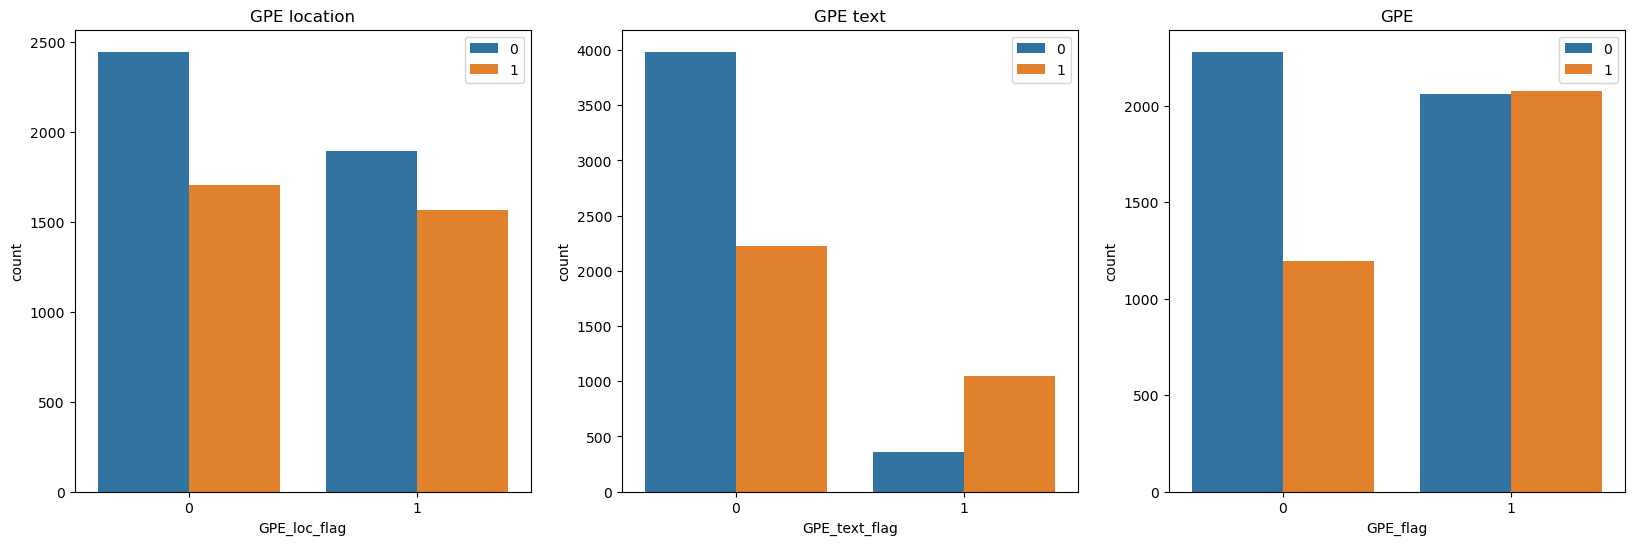

In [34]:
f, axes = plt.subplots(1, 3, figsize=(20,6))
sns.countplot(x='GPE_loc_flag', hue='target', data=df_location, ax=axes[0])
sns.countplot(x='GPE_text_flag', hue='target', data=df_location, ax=axes[1])
sns.countplot(x='GPE_flag', hue='target', data=df_location, ax=axes[2])
axes[0].set_title('GPE location')
axes[1].set_title('GPE text')
axes[2].set_title('GPE')

#plt.xticks(labels=['Not Real Disasters', 'Real Disasters'], ticks=[0, 1])
axes[0].legend(labels=['0', '1'])
axes[1].legend(labels=['0', '1'])
axes[2].legend(labels=['0', '1'])

plt.show()

In [35]:
# Looks like the location extracted from the tweet will be more informative than the original location feature.
df_location.iloc[:, -4:].corr()

,GPE_loc_flag,GPE_text_flag,GPE_flag
GPE_loc_flag,1.000000,0.058926,0.836670
GPE_text_flag,0.058926,1.000000,0.435006
GPE_flag,0.836670,0.435006,1.000000


## Feature Engineering

In [36]:
df_punct_fe = df_train.loc[:, ['id', 'target', 'text']]

In [37]:
#string.punctuation = '!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'
def count_punctuations(text):
    d=dict()
    for i in string.punctuation:
        d[str(i)+' count']=text.count(i)
    return d

In [38]:
df_punct_fe['punct_count'] = df_punct_fe["text"].apply(lambda x:count_punctuations(x))
df_punct= pd.DataFrame(list(df_punct_fe.punct_count))
merge_df = pd.merge(df_punct_fe.target,df_punct,left_index=True, right_index=True)

In [39]:
merge_df_gr = merge_df.groupby('target').sum().reset_index()
merge_df_gr = merge_df_gr.T
merge_df_gr.columns = ['target_0', 'target_1']

In [40]:
merge_df_gr

,target_0,target_1
target,0,1
! count,843,330
""" count",0,0
# count,1700,1703
$ count,32,12
% count,19,27
& count,293,164
' count,2063,1094
( count,207,142
) count,229,144


In [41]:
merge_df_gr['sum_0_1'] = merge_df_gr['target_0'] + merge_df_gr['target_1']

In [42]:
merge_df_gr[merge_df_gr.sum_0_1 > 1000]

,target_0,target_1,sum_0_1
! count,843,330,1173
# count,1700,1703,3403
' count,2063,1094,3157
- count,810,943,1753
. count,5752,5944,11696
/ count,6798,7787,14585
: count,3079,3831,6910
? count,2364,762,3126
@ count,1854,905,2759


In [43]:
merge_df_gr[merge_df_gr.sum_0_1 > 1000]

,target_0,target_1,sum_0_1
! count,843,330,1173
# count,1700,1703,3403
' count,2063,1094,3157
- count,810,943,1753
. count,5752,5944,11696
/ count,6798,7787,14585
: count,3079,3831,6910
? count,2364,762,3126
@ count,1854,905,2759


Our train dataset has 7613 samples so rare punctuation characters are not very informative. From the table above we cat see the most common  characters of real and fake disasters. Most of them have the same distribution, but symbols: !, ?, ', @ are havely used for usual tweets (not for disasters). Let's add the count of them as new columns (exept @, will analisys later).

In [44]:
def punct_add_exclamation(text):
    return len(re.findall("!", text))

In [45]:
def punct_add_question(text):
    return len(re.findall("\?", text))

In [46]:
def punct_add_quotation(text):
    return len(re.findall("'", text))

In [47]:
df_punct_fe['count_exclamation'] = df_punct_fe.text.apply(punct_add_exclamation)
df_punct_fe['count_question'] = df_punct_fe.text.apply(punct_add_question)
df_punct_fe['count_quotation'] = df_punct_fe.text.apply(punct_add_quotation)

In [48]:
new_cols = ['count_exclamation', 'count_question', 'count_quotation']

In [49]:
df_punct_fe.head(2)

,id,target,text,punct_count,count_exclamation,count_question,count_quotation
0,1,1,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,"{'! count': 0, '"" count': 0, '# count': 1, '$ count': 0, '% count': 0, '& count': 0, '' count': 0, '( count': 0, ') count': 0, '* count': 0, '+ count': 0, ', count': 0, '- count': 0, '. count': 0, '/ count': 0, ': count': 0, '; count': 0, '< count': 0, '= count': 0, '> count': 0, '? count': 0, '@ count': 0, '[ count': 0, '\ count': 0, '] count': 0, '^ count': 0, '_ count': 0, '` count': 0, '{ count': 0, '| count': 0, '} count': 0, '~ count': 0}",0,0,0
1,4,1,Forest fire near La Ronge Sask. Canada,"{'! count': 0, '"" count': 0, '# count': 0, '$ count': 0, '% count': 0, '& count': 0, '' count': 0, '( count': 0, ') count': 0, '* count': 0, '+ count': 0, ', count': 0, '- count': 0, '. count': 1, '/ count': 0, ': count': 0, '; count': 0, '< count': 0, '= count': 0, '> count': 0, '? count': 0, '@ count': 0, '[ count': 0, '\ count': 0, '] count': 0, '^ count': 0, '_ count': 0, '` count': 0, '{ count': 0, '| count': 0, '} count': 0, '~ count': 0}",0,0,0


In [50]:
# count number of characters 
def count_chars(text):
    return len(text)

# count number of words 
def count_words(text):
    return len(text.split())

# count number of capital characters
def count_capital_chars(text):
    count=0
    for i in text:
        if i.isupper():
            count+=1
    return count

# count number of capital words
def count_capital_words(text):
    return sum(map(str.isupper,text.split()))

# count number of punctuations
def count_punctuations(text):
    count = lambda l1,l2: sum([1 for x in l1 if x in l2])
    return count(text,set(string.punctuation))

# count number of words in quotes
def count_words_in_quotes(text):
    string_wothout_contractions = ''
    expanded_words = []  
    for each_word in text.split():
        expanded_words.append(contractions.fix(each_word))
    string_wothout_contractions = ' '.join(expanded_words)
    string_wothout_contractions = string_wothout_contractions.replace('"', '\'')
    x = re.findall("\'(.+?)\'", string_wothout_contractions)
    count=0
    if x is None:
        return 0
    else:
        for i in x:
            t=i[1:-1]
            count+=count_words(t)
        return count
    
# count number of sentences
def count_sent(text):
    return len(nltk.sent_tokenize(text))

# count number of unique words 
def count_unique_words(text):
    return len(set(text.split()))
    
# count of hashtags
def count_htags(text):
    x = re.findall(r'(\#\w[A-Za-z0-9]*)', text)
    return len(x)

# count of mentions
def count_mentions(text):
    x = re.findall(r'(\@\w[A-Za-z0-9]*)', text)
    return len(x)

# count of stopwords
def count_stopwords(text):
    stop_words = set(stopwords.words('english'))  
    word_tokens = word_tokenize(text)
    stopwords_x = [w for w in word_tokens if w in stop_words]
    return len(stopwords_x)

#count of links
def count_links(text):
    link_list = re.findall(r'(https?://[^\s]+)', text)
    bitly_list = re.findall(r'bit.ly/\S+', text)
    return (len(link_list + bitly_list))

#count digits
def count_digits(text):
    digit_list = re.findall(r'[0-9]+', text)
    return len(digit_list)

# Factorize repeated punctuation, add REPEAT
def count_repeat_punct(text):
    rep_list = re.findall(r'([!?.]){2,}', text)
    return len(rep_list)

In [51]:
def feature_eng_fun(df_in, text):
    df = copy.deepcopy(df_in)
    df['count_exclamation'] = df_train[text].apply(punct_add_exclamation)
    df['count_question'] = df[text].apply(punct_add_question)
    df['count_quotation'] = df[text].apply(punct_add_quotation)
    df['count_num_of_chars'] = df[text].apply(count_chars)
    df['count_num_of_words'] = df[text].apply(count_words)
    df['count_num_of_capital_chars'] = df[text].apply(count_capital_chars)
    df['count_num_of_capital_words'] = df[text].apply(count_capital_words)
    df['count_punct'] = df[text].apply(count_punctuations)
    df['count_words_in_quotes'] = df[text].apply(count_words_in_quotes)
    df['count_sent'] = df[text].apply(count_sent)
    df['count_unique_words'] = df[text].apply(count_unique_words)
    df['count_htags'] = df[text].apply(count_htags)
    df['count_mentions'] = df[text].apply(count_mentions)
    df['count_htags'] = df[text].apply(count_htags)
    df['count_stopwords'] = df[text].apply(count_stopwords)
    df['count_links'] = df[text].apply(count_links) 
    df['count_repeat_punct'] = df[text].apply(count_repeat_punct)    
    ## This function from part above
    df['GPE_text_flag'] = df[text].apply(show_ents)    
    return df

In [52]:
## .loc will create a new copy, not view
df_feature_eng = df_train.loc[:, ('id', 'text', 'target')]

In [53]:
df_feature_eng = feature_eng_fun(df_feature_eng, 'text')

In [54]:
df_feature_eng.drop(['text'], axis=1, inplace=True)

<AxesSubplot:>

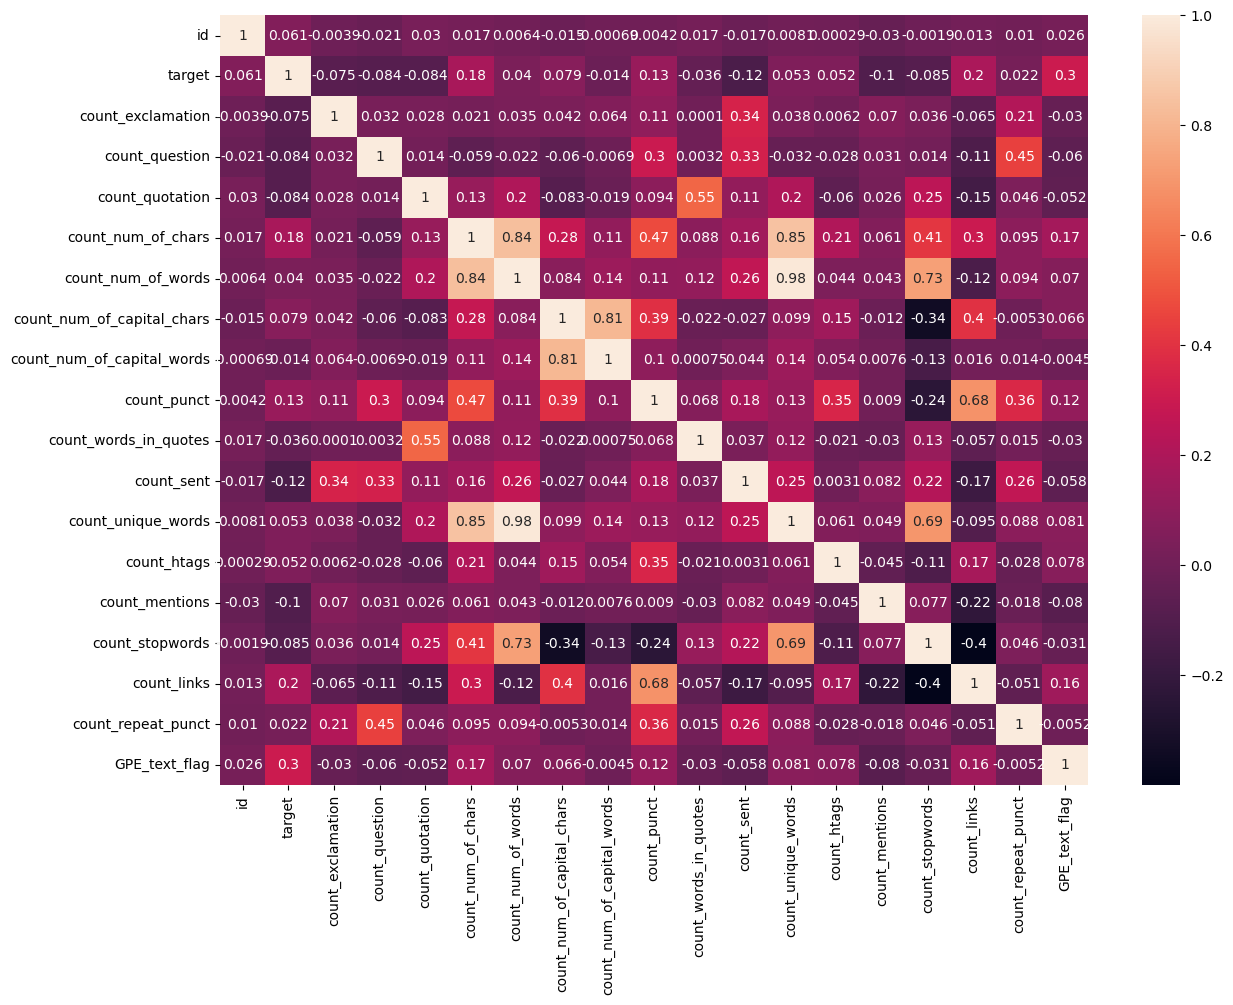

In [55]:
plt.figure(figsize=(14,10))
sns.heatmap(df_feature_eng.corr(),annot=True)

In [56]:
cols_selected = np.abs(df_feature_eng.corr()['target']).sort_values(ascending=False)[1:11].index.to_list()

In [57]:
df_feature_eng[cols_selected].head(3)

,GPE_text_flag,count_links,count_num_of_chars,count_punct,count_sent,count_mentions,count_stopwords,count_question,count_quotation,count_num_of_capital_chars
0,0,0,69,1,1,0,5,0,0,10
1,1,0,38,1,2,0,0,0,0,5
2,0,0,133,3,2,0,9,0,2,2


## Tweets text analysis

In [58]:
# Let's look at some tweets more carefully
df_train[55:60]

,id,keyword,location,text,target
55,79,ablaze,USA,#Kurds trampling on Turkmen flag later set it ablaze while others vandalized offices of Turkmen Front in #Diyala http://t.co/4IzFdYC3cg,1
56,80,ablaze,South Africa,TRUCK ABLAZE : R21. VOORTREKKER AVE. OUTSIDE OR TAMBO INTL. CARGO SECTION. http://t.co/8kscqKfKkF,1
57,81,ablaze,"Sao Paulo, Brazil",Set our hearts ablaze and every city was a gift And every skyline was like a kiss upon the lips @Û_ https://t.co/cYoMPZ1A0Z,0
58,82,ablaze,hollywoodland,They sky was ablaze tonight in Los Angeles. I'm expecting IG and FB to be filled with sunset shots if I know my peeps!!,0
59,83,ablaze,"Edmonton, Alberta - Treaty 6",How the West was burned: Thousands of wildfires ablaze in #California alone http://t.co/iCSjGZ9tE1 #climate #energy http://t.co/9FxmN0l0Bd,1


### Text Preprocessing Functions

In [59]:
abbreviations = {
    "$" : " dollar ",
    "€" : " euro ",
    "4ao" : "for adults only",
    "a.m" : "before midday",
    "a3" : "anytime anywhere anyplace",
    "aamof" : "as a matter of fact",
    "acct" : "account",
    "adih" : "another day in hell",
    "afaic" : "as far as i am concerned",
    "afaict" : "as far as i can tell",
    "afaik" : "as far as i know",
    "afair" : "as far as i remember",
    "afk" : "away from keyboard",
    "app" : "application",
    "approx" : "approximately",
    "apps" : "applications",
    "asap" : "as soon as possible",
    "asl" : "age, sex, location",
    "atk" : "at the keyboard",
    "ave." : "avenue",
    "aymm" : "are you my mother",
    "ayor" : "at your own risk", 
    "b&b" : "bed and breakfast",
    "b+b" : "bed and breakfast",
    "b.c" : "before christ",
    "b2b" : "business to business",
    "b2c" : "business to customer",
    "b4" : "before",
    "b4n" : "bye for now",
    "b@u" : "back at you",
    "bae" : "before anyone else",
    "bak" : "back at keyboard",
    "bbbg" : "bye bye be good",
    "bbc" : "british broadcasting corporation",
    "bbias" : "be back in a second",
    "bbl" : "be back later",
    "bbs" : "be back soon",
    "be4" : "before",
    "bfn" : "bye for now",
    "blvd" : "boulevard",
    "bout" : "about",
    "brb" : "be right back",
    "bros" : "brothers",
    "brt" : "be right there",
    "bsaaw" : "big smile and a wink",
    "btw" : "by the way",
    "bwl" : "bursting with laughter",
    "c/o" : "care of",
    "cet" : "central european time",
    "cf" : "compare",
    "cia" : "central intelligence agency",
    "csl" : "can not stop laughing",
    "cu" : "see you",
    "cul8r" : "see you later",
    "cv" : "curriculum vitae",
    "cwot" : "complete waste of time",
    "cya" : "see you",
    "cyt" : "see you tomorrow",
    "dae" : "does anyone else",
    "dbmib" : "do not bother me i am busy",
    "diy" : "do it yourself",
    "dm" : "direct message",
    "dwh" : "during work hours",
    "e123" : "easy as one two three",
    "eet" : "eastern european time",
    "eg" : "example",
    "embm" : "early morning business meeting",
    "encl" : "enclosed",
    "encl." : "enclosed",
    "etc" : "and so on",
    "faq" : "frequently asked questions",
    "fawc" : "for anyone who cares",
    "fb" : "facebook",
    "fc" : "fingers crossed",
    "fig" : "figure",
    "fimh" : "forever in my heart", 
    "ft." : "feet",
    "ft" : "featuring",
    "ftl" : "for the loss",
    "ftw" : "for the win",
    "fwiw" : "for what it is worth",
    "fyi" : "for your information",
    "g9" : "genius",
    "gahoy" : "get a hold of yourself",
    "gal" : "get a life",
    "gcse" : "general certificate of secondary education",
    "gfn" : "gone for now",
    "gg" : "good game",
    "gl" : "good luck",
    "glhf" : "good luck have fun",
    "gmt" : "greenwich mean time",
    "gmta" : "great minds think alike",
    "gn" : "good night",
    "g.o.a.t" : "greatest of all time",
    "goat" : "greatest of all time",
    "goi" : "get over it",
    "gps" : "global positioning system",
    "gr8" : "great",
    "gratz" : "congratulations",
    "gyal" : "girl",
    "h&c" : "hot and cold",
    "hp" : "horsepower",
    "hr" : "hour",
    "hrh" : "his royal highness",
    "ht" : "height",
    "ibrb" : "i will be right back",
    "ic" : "i see",
    "icq" : "i seek you",
    "icymi" : "in case you missed it",
    "idc" : "i do not care",
    "idgadf" : "i do not give a damn fuck",
    "idgaf" : "i do not give a fuck",
    "idk" : "i do not know",
    "ie" : "that is",
    "i.e" : "that is",
    "ifyp" : "i feel your pain",
    "IG" : "instagram",
    "iirc" : "if i remember correctly",
    "ilu" : "i love you",
    "ily" : "i love you",
    "imho" : "in my humble opinion",
    "imo" : "in my opinion",
    "imu" : "i miss you",
    "iow" : "in other words",
    "irl" : "in real life",
    "j4f" : "just for fun",
    "jic" : "just in case",
    "jk" : "just kidding",
    "jsyk" : "just so you know",
    "l8r" : "later",
    "lb" : "pound",
    "lbs" : "pounds",
    "ldr" : "long distance relationship",
    "lmao" : "laugh my ass off",
    "lmfao" : "laugh my fucking ass off",
    "lol" : "laughing out loud",
    "ltd" : "limited",
    "ltns" : "long time no see",
    "m8" : "mate",
    "mf" : "motherfucker",
    "mfs" : "motherfuckers",
    "mfw" : "my face when",
    "mofo" : "motherfucker",
    "mph" : "miles per hour",
    "mr" : "mister",
    "mrw" : "my reaction when",
    "ms" : "miss",
    "mte" : "my thoughts exactly",
    "nagi" : "not a good idea",
    "nbc" : "national broadcasting company",
    "nbd" : "not big deal",
    "nfs" : "not for sale",
    "ngl" : "not going to lie",
    "nhs" : "national health service",
    "nrn" : "no reply necessary",
    "nsfl" : "not safe for life",
    "nsfw" : "not safe for work",
    "nth" : "nice to have",
    "nvr" : "never",
    "nyc" : "new york city",
    "oc" : "original content",
    "og" : "original",
    "ohp" : "overhead projector",
    "oic" : "oh i see",
    "omdb" : "over my dead body",
    "omg" : "oh my god",
    "omw" : "on my way",
    "p.a" : "per annum",
    "p.m" : "after midday",
    "pm" : "prime minister",
    "poc" : "people of color",
    "pov" : "point of view",
    "pp" : "pages",
    "ppl" : "people",
    "prw" : "parents are watching",
    "ps" : "postscript",
    "pt" : "point",
    "ptb" : "please text back",
    "pto" : "please turn over",
    "qpsa" : "what happens", #"que pasa",
    "ratchet" : "rude",
    "rbtl" : "read between the lines",
    "rlrt" : "real life retweet", 
    "rofl" : "rolling on the floor laughing",
    "roflol" : "rolling on the floor laughing out loud",
    "rotflmao" : "rolling on the floor laughing my ass off",
    "rt" : "retweet",
    "ruok" : "are you ok",
    "sfw" : "safe for work",
    "sk8" : "skate",
    "smh" : "shake my head",
    "sq" : "square",
    "srsly" : "seriously", 
    "ssdd" : "same stuff different day",
    "tbh" : "to be honest",
    "tbs" : "tablespooful",
    "tbsp" : "tablespooful",
    "tfw" : "that feeling when",
    "thks" : "thank you",
    "tho" : "though",
    "thx" : "thank you",
    "tia" : "thanks in advance",
    "til" : "today i learned",
    "tl;dr" : "too long i did not read",
    "tldr" : "too long i did not read",
    "tmb" : "tweet me back",
    "tntl" : "trying not to laugh",
    "ttyl" : "talk to you later",
    "u" : "you",
    "u2" : "you too",
    "u4e" : "yours for ever",
    "utc" : "coordinated universal time",
    "w/" : "with",
    "w/o" : "without",
    "w8" : "wait",
    "wassup" : "what is up",
    "wb" : "welcome back",
    "wtf" : "what the fuck",
    "wtg" : "way to go",
    "wtpa" : "where the party at",
    "wuf" : "where are you from",
    "wuzup" : "what is up",
    "wywh" : "wish you were here",
    "yd" : "yard",
    "ygtr" : "you got that right",
    "ynk" : "you never know",
    "zzz" : "sleeping bored and tired"
}

In [60]:
#remove not ascii
def delete_not_ascii(text):
    text = re.sub(r'[^\x00-\x7f]', '', text)
    return text 

#remove urls
def remove_urls(text):
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    return text

# Change an abbreviation by its true meaning
def word_abbrev(word):
    return abbreviations[word.lower()] if word.lower() in abbreviations.keys() else word

# Replace all abbreviations
def replace_abbrev(text):
    string = ""
    for word in text.split():
        string += word_abbrev(word) + " "        
    return string

# Remove @ and mention, replace by USER
def replace_mention(text):
    pat=re.compile(r'@\S+')
    return pat.sub(r'USER',text)

# Remove numbers, replace it by NUMBER
def remove_number(text):
    num = re.compile(r'[-+]?[.\d]*[\d]+[:,.\d]*')
    return num.sub(r' NUMBER ', text)

#remove punctuation
def remove_punct(text):
    text = re.sub('[' + string.punctuation +']', ' ', text)
    return text     

# remove line breaks and extra spaces
def clean_text(text):
    text = re.sub(r'\n',' ', text) # Remove line breaks
    text = re.sub('\s+', ' ', text).strip() # Remove leading, trailing, and extra spaces
    return text

def convert_lower_case(text):
    return text.lower()

#contractions and remowing stopwords and very short words
def string_contractions(text):
    string_wothout_contractions = ''
    expanded_words = []  
    for each_word in text.split():
        if each_word not in (STOPWORDS):
            if len(each_word) >= 3:
                expanded_words.append(contractions.fix(each_word))
    string_wothout_contractions = ' '.join(expanded_words)
    return string_wothout_contractions



In [61]:
def basic_cleaning(df_in, column_name):
    df = copy.deepcopy(df_in)
    df[column_name] = df[column_name].apply(delete_not_ascii)
    df[column_name] = df[column_name].apply(remove_urls)
    df[column_name] = df[column_name].apply(replace_abbrev)
    df[column_name] = df[column_name].apply(replace_mention) 
    df[column_name] = df[column_name].apply(remove_number)
    df[column_name] = df[column_name].apply(convert_lower_case)
    df[column_name] = df[column_name].apply(string_contractions)
    df[column_name] = df[column_name].apply(remove_punct)
    df[column_name] = df[column_name].apply(clean_text)
    return df
    

In [62]:
df_text = df_train.loc[:, ['id', 'target', 'keyword', 'text']]

In [63]:
df_text = basic_cleaning(df_text, 'text')

In [64]:
df_text.head(3)

,id,target,keyword,text
0,1,1,NaN,deeds reason earthquake may allah forgive
1,4,1,NaN,forest fire near ronge sask canada
2,5,1,NaN,residents asked shelter place notified officers evacuation shelter place orders expected


### OOV

In [65]:
all_text = ' '.join(df_text['text'].tolist())

In [66]:
oov_list = []
def search_oov(text):
    tokens = nlp(text)
    for token in tokens:
        if token.is_oov:
            oov_list.append(token)

In [67]:
search_oov(all_text)

In [68]:
oov_list_strings  = [i.text for i in oov_list]

In [69]:
counter = Counter(oov_list_strings)
counter.most_common(10)

[('prebreak', 30),
 ('soudelor', 26),
 ('bestnaijamade', 24),
 ('gbbo', 21),
 ('disea', 19),
 ('funtenna', 17),
 ('bayelsa', 16),
 ('marians', 14),
 ('udhampur', 13),
 ('sismo', 10)]

In [70]:
# I don't see a critical oov words, so I won't replace anything

### Sentiment Analyzer

In [71]:
sid = SentimentIntensityAnalyzer()

In [72]:
df_sentiment = df_train.loc[:, ['id', 'target', 'text']]

In [73]:
df_sentiment['sentiment_compound']  = df_sentiment.text.apply(lambda tweet: sid.polarity_scores(tweet)['compound'])

In [74]:
df_sentiment['sentiment_compound_score'] = df_sentiment['sentiment_compound'].apply(lambda c: 'pos' if c >=0 else 'neg')

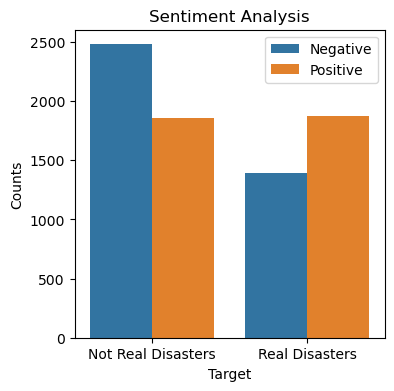

In [75]:
plt.figure(figsize=[4, 4])
sns.countplot(x='target', hue='sentiment_compound_score', data=df_sentiment)
plt.title('Sentiment Analysis')
plt.xticks(labels=['Not Real Disasters', 'Real Disasters'], ticks=[0, 1])
plt.xlabel('Target')
plt.ylabel('Counts')
plt.legend(labels=['Negative', 'Positive'])
plt.show()

In [76]:
#not very optimistic result, I won't add a sentiment feature :)

In [77]:
## CREATE A MODEL BASED ON TEXT

There are two options for the dataset:
1. Based on text only
2. Based on the text and new features like the count of characters

Let's check both approaches.

In [78]:
### with eng features

In [79]:
df_copy = copy.deepcopy(df_train)

In [80]:
cols_selected = ['GPE_text_flag', 'count_links', 'count_num_of_chars', 'count_punct', 'count_sent',
                 'count_mentions', 'count_stopwords', 'count_question', 'count_quotation',
                 'count_num_of_capital_chars']

df_copy = copy.deepcopy(df_train)
df_train_text_clean = basic_cleaning(df_copy, 'text')
df_train_text_clean["clean_text"] = df_train_text_clean.keyword.map(str) + " " + df_train_text_clean.text

## new features
df_train_feature_eng = feature_eng_fun(df_copy, 'text')
df_train_feature_eng = df_train_feature_eng[cols_selected]


#### for test
df_test_text_clean_f = basic_cleaning(df_test, 'text')
df_test_text_clean_f["clean_text"] = df_test_text_clean_f.keyword.map(str) + " " + df_test_text_clean_f.text

df_test_feature_eng_f = feature_eng_fun(df_test, 'text')
df_test_feature_eng_f = df_test_feature_eng_f[cols_selected]

In [81]:
## ADD LEMMATIZATION
w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
def lemmatize_text(text):
    return [wnl.lemmatize(w) for w in w_tokenizer.tokenize(text)]

df_train_text_clean['text_lemmatized'] = df_train_text_clean.clean_text.apply(lemmatize_text)
df_train_text_clean['all_text'] = df_train_text_clean['text_lemmatized'].apply(lambda x: " ".join(x))

df_test_text_clean_f['text_lemmatized'] = df_test_text_clean_f.clean_text.apply(lemmatize_text)
df_test_text_clean_f['all_text'] = df_test_text_clean_f['text_lemmatized'].apply(lambda x: " ".join(x))

In [82]:
text_column = 'all_text'

In [83]:
df_train_full = pd.merge(df_train_text_clean[['target', text_column]], df_train_feature_eng, 
                         left_index=True, right_index=True)

df_test_full = pd.merge(df_test_text_clean_f[[text_column]], df_test_feature_eng_f, 
                         left_index=True, right_index=True)

In [84]:
## split to test and train
y = df_train_full['target']
X = df_train_full.drop('target', axis=1)
# This dataset is unbalanced so add stratify parameter for splitting
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, shuffle=True)
print('X_train shape', X_train.shape)
print('X_test shape', X_test.shape)

X_train shape (5329, 11)
X_test shape (2284, 11)


In [85]:
max_features=15000

# CountVectorizer
count_vectorizer = CountVectorizer(max_features=max_features)

def count_vector(data):
    count_vectorizer = CountVectorizer()
    vect = count_vectorizer.fit_transform(data)
    return vect, count_vectorizer

def tfidf_vector(data):
    tfidf_vectorizer = TfidfVectorizer()
    vect = tfidf_vectorizer.fit_transform(data)
    return vect, tfidf_vectorizer

def min_max(data):
    min_max_scaler = MinMaxScaler()
    vect = min_max_scaler.fit_transform(data)
    return vect, min_max_scaler

# TRAIN
X_train_count, count_vectorizer = count_vector(X_train[text_column])
X_train_tfidf, tfidf_vectorizer = tfidf_vector(X_train[text_column])

X_train_eng_minmax, minmax_scaler = min_max(X_train[cols_selected])
X_train_eng = X_train[cols_selected].to_numpy()

#### TEST
X_test_count = count_vectorizer.transform(X_test [text_column])                                                     
X_test_tfidf = tfidf_vectorizer.transform(X_test [text_column])

X_test_eng_minmax = minmax_scaler.transform(X_test[cols_selected])
X_test_eng = X_test[cols_selected].to_numpy()

### VALIDATION DATASET
X_test_count_f = count_vectorizer.transform(df_test_full[text_column])                                                     
X_test_tfidf_f = tfidf_vectorizer.transform(df_test_full[text_column])

X_test_eng_minmax_f = minmax_scaler.transform(df_test_full[cols_selected])
X_test_eng_f = df_test_full[cols_selected].to_numpy()


### CONCAT tf-idf + minmax, count_vec + feature_eng

X_train_tfidf_minmax = hstack([X_train_tfidf, X_train_eng_minmax])
X_train_count_eng = hstack([X_train_count, X_train_eng])


X_test_tfidf_minmax = hstack([X_test_tfidf, X_test_eng_minmax])
X_test_count_eng = hstack([X_test_count, X_test_eng])

### FOR VALIDATION DATASET
X_test_tfidf_minmax_f = hstack([X_test_tfidf_f, X_test_eng_minmax_f])
X_test_count_eng_f = hstack([X_test_count_f, X_test_eng_f])

In [133]:
X_train_count

<5329x10264 sparse matrix of type '<class 'numpy.int64'>'
	with 49196 stored elements in Compressed Sparse Row format>

In [135]:
#from scipy import sparse
#### SAVE ALL DF
#sparse.save_npz("../data/X_train_count.npz", X_train_count)
#sparse.save_npz("../data/X_train_tfidf.npz", X_train_tfidf)
#
#sparse.save_npz("../data/X_test_count.npz", X_test_count)
#sparse.save_npz("../data/X_test_tfidf.npz", X_test_tfidf)
#
#sparse.save_npz("../data/X_train_tfidf_minmax.npz", X_train_tfidf_minmax)
#sparse.save_npz("../data/X_train_count_eng.npz", X_train_count_eng)
#
#sparse.save_npz("../data/X_test_tfidf_minmax.npz", X_test_tfidf_minmax)
#sparse.save_npz("../data/X_test_count_eng.npz", X_test_count_eng)
#
##########
#sparse.save_npz("../data/X_test_count_f.npz", X_test_count_f)
#sparse.save_npz("../data/X_test_tfidf_f.npz", X_test_tfidf_f)
#sparse.save_npz("../data/X_test_count_eng_f.npz", X_test_count_eng_f)
#sparse.save_npz("../data/X_test_tfidf_minmax_f.npz", X_test_tfidf_minmax_f)

In [86]:
#
#with open('count_vectorizer.pickle', 'wb') as handle:
#    pickle.dump(count_vectorizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
#with open('tfidf_vectorizer.pickle', 'wb') as handle:
#    pickle.dump(tfidf_vectorizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
#with open('minmax_scaler.pickle', 'wb') as handle:
#    pickle.dump(minmax_scaler, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [87]:
#functions for searching best threshold
def to_labels(pos_probs, threshold):
    return (pos_probs >= threshold).astype('int')

def best_tresholds(y_pred_proba, y_test):
    # define thresholds
    thresholds = np.arange(0, 1, 0.001)
    # evaluate each threshold
    scores = [f1_score(y_test, to_labels(y_pred_proba, t)) for t in thresholds]
    # get best threshold
    ix = np.argmax(scores)
    #print('Threshold=%.3f, F-Score=%.5f' % (thresholds[ix], scores[ix]))
    return thresholds[ix], scores[ix]

In [88]:
#create a df for saving results of each model
metrics = pd.DataFrame(columns=['model' ,'vectoriser', 'f1 score', 'best_f1', 'threshold', 
                                'train accuracy','test accuracy'])

In [89]:
def fit_and_predict(model, x_train ,x_test, y_train, y_test, vectoriser):
    classifier = model
    classifier_name = str(classifier.__class__.__name__)


    classifier.fit(x_train,y_train)

    y_pred = classifier.predict(x_test)
    cmatrix = confusion_matrix(y_test,y_pred)
    
    y_hat = classifier.predict_proba(x_test)[:,1]
    threshold, best_score = best_tresholds(y_hat, y_test)


    f1score = f1_score(y_test,y_pred)
    train_accuracy = round(classifier.score(x_train,y_train)*100)
    test_accuracy =  round(accuracy_score(y_test,y_pred)*100)

    global metrics
    metrics = metrics.append({
                              'model': classifier_name,
                              'f1 score': f1score, 
                              'best_f1': best_score,
                              'threshold': threshold,
                              'train accuracy': train_accuracy, 
                              'test accuracy': test_accuracy, 
                              'vectoriser': str(vectoriser),
                             },
                               ignore_index=True
                            )

    print(str(classifier.__class__.__name__) +" using "+ str(vectoriser))
    print('f1 score for test: {}'.format(f1score))
    print(classification_report(y_test,y_pred))    
    print('Threshold={:.5f}, F-Score={:.5f}'.format(threshold, best_score))
    print('Accuracy of classifier on training set:{}%'.format(train_accuracy))
    print('Accuracy of classifier on test set:{}%' .format(test_accuracy))

In [90]:
models=[
        LogisticRegression(random_state=30),
        SVC(random_state=30, probability=True),
        MultinomialNB(),
        DecisionTreeClassifier(random_state = 30),
        KNeighborsClassifier(),
        RandomForestClassifier(random_state=30, max_depth=4),
       ]

In [91]:
for model in models:
    ## only text Count vector
    fit_and_predict(model, X_train_count, X_test_count, y_train ,y_test, 'Count vector')
    
    fit_and_predict(model, X_train_tfidf, X_test_tfidf, y_train, y_test, 'Tfidf vector')
    
    ## count with EF
    fit_and_predict(model, X_train_count_eng, X_test_count_eng, y_train, y_test, 'Count vector + FE')
    
    ## TF IDF with EF
    fit_and_predict(model, X_train_tfidf_minmax, X_test_tfidf_minmax, y_train, y_test, 'TF-IDF + FE')   

C:\Users\Me\AppData\Local\Temp\ipykernel_30092\2469719882.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({


LogisticRegression using Count vector
f1 score for test: 0.7419880499728408
              precision    recall  f1-score   support

           0       0.79      0.86      0.83      1303
           1       0.79      0.70      0.74       981

    accuracy                           0.79      2284
   macro avg       0.79      0.78      0.78      2284
weighted avg       0.79      0.79      0.79      2284

Threshold=0.38600, F-Score=0.75038
Accuracy of classifier on training set:95%
Accuracy of classifier on test set:79%


C:\Users\Me\AppData\Local\Temp\ipykernel_30092\2469719882.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({


LogisticRegression using Tfidf vector
f1 score for test: 0.732596685082873
              precision    recall  f1-score   support

           0       0.78      0.87      0.82      1303
           1       0.80      0.68      0.73       981

    accuracy                           0.79      2284
   macro avg       0.79      0.77      0.78      2284
weighted avg       0.79      0.79      0.79      2284

Threshold=0.37600, F-Score=0.74386
Accuracy of classifier on training set:88%
Accuracy of classifier on test set:79%


C:\Users\Me\Anaconda3\envs\tf-gpu\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Me\AppData\Local\Temp\ipykernel_30092\2469719882.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({


LogisticRegression using Count vector + FE
f1 score for test: 0.7127312295973885
              precision    recall  f1-score   support

           0       0.77      0.84      0.81      1303
           1       0.76      0.67      0.71       981

    accuracy                           0.77      2284
   macro avg       0.77      0.76      0.76      2284
weighted avg       0.77      0.77      0.77      2284

Threshold=0.35000, F-Score=0.73398
Accuracy of classifier on training set:81%
Accuracy of classifier on test set:77%


C:\Users\Me\AppData\Local\Temp\ipykernel_30092\2469719882.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({


LogisticRegression using TF-IDF + FE
f1 score for test: 0.7460055096418731
              precision    recall  f1-score   support

           0       0.79      0.88      0.83      1303
           1       0.81      0.69      0.75       981

    accuracy                           0.80      2284
   macro avg       0.80      0.78      0.79      2284
weighted avg       0.80      0.80      0.80      2284

Threshold=0.46800, F-Score=0.75766
Accuracy of classifier on training set:87%
Accuracy of classifier on test set:80%


C:\Users\Me\AppData\Local\Temp\ipykernel_30092\2469719882.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({


SVC using Count vector
f1 score for test: 0.7212364052661706
              precision    recall  f1-score   support

           0       0.77      0.90      0.83      1303
           1       0.82      0.64      0.72       981

    accuracy                           0.79      2284
   macro avg       0.80      0.77      0.77      2284
weighted avg       0.79      0.79      0.78      2284

Threshold=0.29800, F-Score=0.74818
Accuracy of classifier on training set:93%
Accuracy of classifier on test set:79%


C:\Users\Me\AppData\Local\Temp\ipykernel_30092\2469719882.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({


SVC using Tfidf vector
f1 score for test: 0.7257336343115125
              precision    recall  f1-score   support

           0       0.77      0.89      0.83      1303
           1       0.81      0.66      0.73       981

    accuracy                           0.79      2284
   macro avg       0.79      0.77      0.78      2284
weighted avg       0.79      0.79      0.78      2284

Threshold=0.34800, F-Score=0.74827
Accuracy of classifier on training set:95%
Accuracy of classifier on test set:79%


C:\Users\Me\AppData\Local\Temp\ipykernel_30092\2469719882.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({


SVC using Count vector + FE
f1 score for test: 0.5046403712296984
              precision    recall  f1-score   support

           0       0.65      0.76      0.70      1303
           1       0.59      0.44      0.50       981

    accuracy                           0.63      2284
   macro avg       0.62      0.60      0.60      2284
weighted avg       0.62      0.63      0.62      2284

Threshold=0.31600, F-Score=0.65669
Accuracy of classifier on training set:64%
Accuracy of classifier on test set:63%


C:\Users\Me\AppData\Local\Temp\ipykernel_30092\2469719882.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({


SVC using TF-IDF + FE
f1 score for test: 0.7344632768361581
              precision    recall  f1-score   support

           0       0.78      0.89      0.83      1303
           1       0.82      0.66      0.73       981

    accuracy                           0.79      2284
   macro avg       0.80      0.78      0.78      2284
weighted avg       0.80      0.79      0.79      2284

Threshold=0.41400, F-Score=0.76077
Accuracy of classifier on training set:92%
Accuracy of classifier on test set:79%


C:\Users\Me\AppData\Local\Temp\ipykernel_30092\2469719882.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({


MultinomialNB using Count vector
f1 score for test: 0.7474854420328216
              precision    recall  f1-score   support

           0       0.80      0.84      0.82      1303
           1       0.78      0.72      0.75       981

    accuracy                           0.79      2284
   macro avg       0.79      0.78      0.78      2284
weighted avg       0.79      0.79      0.79      2284

Threshold=0.50200, F-Score=0.74788
Accuracy of classifier on training set:90%
Accuracy of classifier on test set:79%


C:\Users\Me\AppData\Local\Temp\ipykernel_30092\2469719882.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({


MultinomialNB using Tfidf vector
f1 score for test: 0.7315968289920725
              precision    recall  f1-score   support

           0       0.78      0.89      0.83      1303
           1       0.82      0.66      0.73       981

    accuracy                           0.79      2284
   macro avg       0.80      0.78      0.78      2284
weighted avg       0.80      0.79      0.79      2284

Threshold=0.46100, F-Score=0.74690
Accuracy of classifier on training set:89%
Accuracy of classifier on test set:79%


C:\Users\Me\AppData\Local\Temp\ipykernel_30092\2469719882.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({


MultinomialNB using Count vector + FE
f1 score for test: 0.7449521785334751
              precision    recall  f1-score   support

           0       0.80      0.85      0.82      1303
           1       0.78      0.71      0.74       981

    accuracy                           0.79      2284
   macro avg       0.79      0.78      0.78      2284
weighted avg       0.79      0.79      0.79      2284

Threshold=0.30500, F-Score=0.74848
Accuracy of classifier on training set:88%
Accuracy of classifier on test set:79%


C:\Users\Me\AppData\Local\Temp\ipykernel_30092\2469719882.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({


MultinomialNB using TF-IDF + FE
f1 score for test: 0.734418865805727
              precision    recall  f1-score   support

           0       0.78      0.89      0.83      1303
           1       0.82      0.67      0.73       981

    accuracy                           0.79      2284
   macro avg       0.80      0.78      0.78      2284
weighted avg       0.80      0.79      0.79      2284

Threshold=0.39600, F-Score=0.74936
Accuracy of classifier on training set:87%
Accuracy of classifier on test set:79%


C:\Users\Me\AppData\Local\Temp\ipykernel_30092\2469719882.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({


DecisionTreeClassifier using Count vector
f1 score for test: 0.6822633297062024
              precision    recall  f1-score   support

           0       0.75      0.82      0.79      1303
           1       0.73      0.64      0.68       981

    accuracy                           0.74      2284
   macro avg       0.74      0.73      0.73      2284
weighted avg       0.74      0.74      0.74      2284

Threshold=0.37600, F-Score=0.68424
Accuracy of classifier on training set:99%
Accuracy of classifier on test set:74%


C:\Users\Me\AppData\Local\Temp\ipykernel_30092\2469719882.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({


DecisionTreeClassifier using Tfidf vector
f1 score for test: 0.6652697747511787
              precision    recall  f1-score   support

           0       0.74      0.78      0.76      1303
           1       0.68      0.65      0.67       981

    accuracy                           0.72      2284
   macro avg       0.71      0.71      0.71      2284
weighted avg       0.72      0.72      0.72      2284

Threshold=0.37600, F-Score=0.66770
Accuracy of classifier on training set:99%
Accuracy of classifier on test set:72%


C:\Users\Me\AppData\Local\Temp\ipykernel_30092\2469719882.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({


DecisionTreeClassifier using Count vector + FE
f1 score for test: 0.6593406593406592
              precision    recall  f1-score   support

           0       0.74      0.82      0.77      1303
           1       0.72      0.61      0.66       981

    accuracy                           0.73      2284
   macro avg       0.73      0.71      0.72      2284
weighted avg       0.73      0.73      0.72      2284

Threshold=0.20100, F-Score=0.66194
Accuracy of classifier on training set:99%
Accuracy of classifier on test set:73%


C:\Users\Me\AppData\Local\Temp\ipykernel_30092\2469719882.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({


DecisionTreeClassifier using TF-IDF + FE
f1 score for test: 0.6379310344827587
              precision    recall  f1-score   support

           0       0.72      0.78      0.75      1303
           1       0.68      0.60      0.64       981

    accuracy                           0.71      2284
   macro avg       0.70      0.69      0.70      2284
weighted avg       0.70      0.71      0.70      2284

Threshold=0.20100, F-Score=0.64103
Accuracy of classifier on training set:99%
Accuracy of classifier on test set:71%


C:\Users\Me\AppData\Local\Temp\ipykernel_30092\2469719882.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({


KNeighborsClassifier using Count vector
f1 score for test: 0.6349583828775267
              precision    recall  f1-score   support

           0       0.72      0.87      0.79      1303
           1       0.76      0.54      0.63       981

    accuracy                           0.73      2284
   macro avg       0.74      0.71      0.71      2284
weighted avg       0.74      0.73      0.72      2284

Threshold=0.20100, F-Score=0.66793
Accuracy of classifier on training set:82%
Accuracy of classifier on test set:73%


C:\Users\Me\AppData\Local\Temp\ipykernel_30092\2469719882.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({


KNeighborsClassifier using Tfidf vector
f1 score for test: 0.6869658119658121
              precision    recall  f1-score   support

           0       0.76      0.81      0.78      1303
           1       0.72      0.66      0.69       981

    accuracy                           0.74      2284
   macro avg       0.74      0.73      0.73      2284
weighted avg       0.74      0.74      0.74      2284

Threshold=0.20100, F-Score=0.69083
Accuracy of classifier on training set:83%
Accuracy of classifier on test set:74%


C:\Users\Me\AppData\Local\Temp\ipykernel_30092\2469719882.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({


KNeighborsClassifier using Count vector + FE
f1 score for test: 0.5577244841048522
              precision    recall  f1-score   support

           0       0.67      0.76      0.71      1303
           1       0.62      0.51      0.56       981

    accuracy                           0.65      2284
   macro avg       0.64      0.64      0.64      2284
weighted avg       0.65      0.65      0.65      2284

Threshold=0.00100, F-Score=0.61786
Accuracy of classifier on training set:76%
Accuracy of classifier on test set:65%


C:\Users\Me\AppData\Local\Temp\ipykernel_30092\2469719882.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({


KNeighborsClassifier using TF-IDF + FE
f1 score for test: 0.7193717277486911
              precision    recall  f1-score   support

           0       0.78      0.81      0.80      1303
           1       0.74      0.70      0.72       981

    accuracy                           0.77      2284
   macro avg       0.76      0.76      0.76      2284
weighted avg       0.76      0.77      0.76      2284

Threshold=0.40100, F-Score=0.71937
Accuracy of classifier on training set:83%
Accuracy of classifier on test set:77%


C:\Users\Me\AppData\Local\Temp\ipykernel_30092\2469719882.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({


RandomForestClassifier using Count vector
f1 score for test: 0.06508875739644969
              precision    recall  f1-score   support

           0       0.58      1.00      0.73      1303
           1       1.00      0.03      0.07       981

    accuracy                           0.58      2284
   macro avg       0.79      0.52      0.40      2284
weighted avg       0.76      0.58      0.45      2284

Threshold=0.42300, F-Score=0.68374
Accuracy of classifier on training set:60%
Accuracy of classifier on test set:58%


C:\Users\Me\AppData\Local\Temp\ipykernel_30092\2469719882.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({


RandomForestClassifier using Tfidf vector
f1 score for test: 0.06699507389162562
              precision    recall  f1-score   support

           0       0.58      1.00      0.73      1303
           1       1.00      0.03      0.07       981

    accuracy                           0.59      2284
   macro avg       0.79      0.52      0.40      2284
weighted avg       0.76      0.59      0.45      2284

Threshold=0.42300, F-Score=0.69037
Accuracy of classifier on training set:59%
Accuracy of classifier on test set:59%


C:\Users\Me\AppData\Local\Temp\ipykernel_30092\2469719882.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({


RandomForestClassifier using Count vector + FE
f1 score for test: 0.1451460885956645
              precision    recall  f1-score   support

           0       0.59      1.00      0.74      1303
           1       0.96      0.08      0.15       981

    accuracy                           0.60      2284
   macro avg       0.78      0.54      0.44      2284
weighted avg       0.75      0.60      0.49      2284

Threshold=0.42400, F-Score=0.69076
Accuracy of classifier on training set:61%
Accuracy of classifier on test set:60%
RandomForestClassifier using TF-IDF + FE
f1 score for test: 0.1675977653631285
              precision    recall  f1-score   support

           0       0.59      1.00      0.74      1303
           1       0.97      0.09      0.17       981

    accuracy                           0.61      2284
   macro avg       0.78      0.54      0.46      2284
weighted avg       0.75      0.61      0.50      2284

Threshold=0.42500, F-Score=0.68880
Accuracy of classifier on trai

C:\Users\Me\AppData\Local\Temp\ipykernel_30092\2469719882.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({


In [92]:
metrics.sort_values('best_f1')

,model,vectoriser,f1 score,best_f1,threshold,train accuracy,test accuracy
18,KNeighborsClassifier,Count vector + FE,0.557724,0.617864,0.001,76,65
15,DecisionTreeClassifier,TF-IDF + FE,0.637931,0.641026,0.201,99,71
6,SVC,Count vector + FE,0.504640,0.656694,0.316,64,63
14,DecisionTreeClassifier,Count vector + FE,0.659341,0.661941,0.201,99,73
13,DecisionTreeClassifier,Tfidf vector,0.665270,0.667703,0.376,99,72
16,KNeighborsClassifier,Count vector,0.634958,0.667926,0.201,82,73
20,RandomForestClassifier,Count vector,0.065089,0.683744,0.423,60,58
12,DecisionTreeClassifier,Count vector,0.682263,0.684239,0.376,99,74
23,RandomForestClassifier,TF-IDF + FE,0.167598,0.688805,0.425,62,61
21,RandomForestClassifier,Tfidf vector,0.066995,0.690370,0.423,59,59


In [93]:
metrics.to_csv('classification_models_score.csv')

In [94]:
### LogReg and SVC show a good result. I want to tune the hyperparameters for the SVC to improve the quality of the classification.

In [95]:
param_grid = {'C': [12, 13, 14], 
              'gamma': [0.1, 0.07, 0.05],
              'kernel': ['rbf']}

In [96]:
from sklearn.model_selection import StratifiedKFold
StratifiedKFold(n_splits=3, random_state=None, shuffle=False)

StratifiedKFold(n_splits=3, random_state=None, shuffle=False)

In [97]:
### CREATE A FILE WITH THE RESULTS OF EACH MODEL IN GRIDSEARCHCV
#In .log files are results of Gridsearchcv. I tried different hyperparameters and datasets 
#and this score is the best one.

old_stdout = sys.stdout
log_file = open("SVC_tfidf_vect_3.log","w")
sys.stdout = log_file

In [98]:
grid = GridSearchCV(SVC(probability=True),param_grid,cv=StratifiedKFold(),verbose=0,scoring='f1')
grid.fit(X_train_tfidf_minmax,y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=SVC(probability=True),
             param_grid={'C': [12, 13, 14], 'gamma': [0.1, 0.07, 0.05],
                         'kernel': ['rbf']},
             scoring='f1')

In [99]:
sys.stdout = old_stdout
log_file.close()

In [101]:
print('Best hyperparameters: ', grid.best_params_)
print('Best score: ', grid.best_score_)

Best hyperparameters:  {'C': 13, 'gamma': 0.05, 'kernel': 'rbf'}
Best score:  0.7619863678011773


In [102]:
svc_best = grid.best_estimator_
### test df
y_predict_proba_svc = svc_best.predict_proba(X_test_tfidf_minmax)
y_pred_svc = svc_best.predict(X_test_tfidf_minmax)
print(f1_score(y_test, y_pred_svc))

### validation df
y_predict_proba_svc_f = svc_best.predict_proba(X_test_tfidf_minmax_f)[:,1]

0.7463335143943508


In [120]:
#So, on Kaggle the better result was shown with treshold = 0.5 --> Score: 0.80018
df_t = df_test[['id']]
df_t['target'] = (y_predict_proba_svc_f >= 0.5).astype(int)
df_t.to_csv("submission_svm_05.csv", index=False)

C:\Users\Me\AppData\Local\Temp\ipykernel_30092\1410868228.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_t['target'] = (y_predict_proba_svc_f >= 0.5).astype(int)


In [121]:
df_t.describe()

,id,target
count,3263.000000,3263.000000
mean,5427.152927,0.385535
std,3146.427221,0.486796
min,0.000000,0.000000
25%,2683.000000,0.000000
50%,5500.000000,0.000000
75%,8176.000000,1.000000
max,10875.000000,1.000000


In [186]:
from sklearn.decomposition import TruncatedSVD

In [193]:
svd = TruncatedSVD(n_components = 1000)
svd.fit(X_train_tfidf_minmax)

TruncatedSVD(n_components=1000)

In [194]:
#with open('TruncatedSVD_1000.pickle', 'wb') as handle:
#    pickle.dump(svd, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [195]:
#svd = pickle.load(open('TruncatedSVD_500.pickle', 'rb'))

In [196]:
X_train_svd = svd.transform(X_train_tfidf_minmax)
X_test_svd = svd.transform(X_test_tfidf_minmax)
X_test_svd_f = svd.transform(X_test_tfidf_minmax_f)

In [197]:
X_train_svd.shape

(5329, 1000)

In [198]:
svc_best = grid.best_estimator_
svc_best.fit(X_train_svd, y_train)

y_predict_proba_svc_svd = svc_best.predict_proba(X_test_svd)
y_pred_svc_svd = svc_best.predict(X_test_svd)
print(f1_score(y_test, y_pred_svc_svd))

0.7457063711911358


In [ ]:
0.7420 ## 750
0.7457063 ## 1000
0.7443650357339198 ## 1500

In [204]:
param_grid = {'C': [13, 15, 17], 'gamma': [0.07, 0.05, 0.03],'kernel': ['rbf']}

In [205]:
 #1 / (1000 * X_train_svd.var())

In [206]:
grid_svd = GridSearchCV(SVC(probability=True),param_grid,cv=StratifiedKFold(),verbose=10,scoring='f1')
grid_svd.fit(X_train_svd,y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV 1/5; 1/9] START C=13, gamma=0.07, kernel=rbf................................
[CV 1/5; 1/9] END .C=13, gamma=0.07, kernel=rbf;, score=0.750 total time=  49.4s
[CV 2/5; 1/9] START C=13, gamma=0.07, kernel=rbf................................
[CV 2/5; 1/9] END .C=13, gamma=0.07, kernel=rbf;, score=0.758 total time=  48.3s
[CV 3/5; 1/9] START C=13, gamma=0.07, kernel=rbf................................
[CV 3/5; 1/9] END .C=13, gamma=0.07, kernel=rbf;, score=0.751 total time=  50.4s
[CV 4/5; 1/9] START C=13, gamma=0.07, kernel=rbf................................
[CV 4/5; 1/9] END .C=13, gamma=0.07, kernel=rbf;, score=0.763 total time=  49.0s
[CV 5/5; 1/9] START C=13, gamma=0.07, kernel=rbf................................
[CV 5/5; 1/9] END .C=13, gamma=0.07, kernel=rbf;, score=0.754 total time=  49.6s
[CV 1/5; 2/9] START C=13, gamma=0.05, kernel=rbf................................
[CV 1/5; 2/9] END .C=13, gamma=0.05, kernel=rbf;,

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=SVC(probability=True),
             param_grid={'C': [13, 15, 17], 'gamma': [0.07, 0.05, 0.03],
                         'kernel': ['rbf']},
             scoring='f1', verbose=10)

In [207]:
grid_svd.best_params_

{'C': 13, 'gamma': 0.05, 'kernel': 'rbf'}

In [208]:
svd_svc = grid_svd.best_estimator_

In [209]:
grid_svd.best_score_

0.7582750343044112

In [210]:
y_pred_svc_svd = svd_svc.predict(X_test_svd)
y_predict_proba_svc_svd = svd_svc.predict_proba(X_test_svd)[:,1]
print(f1_score(y_test, y_pred_svc))

0.7463335143943508


In [211]:
best_tresholds(y_predict_proba_svc_svd, y_test)

(0.395, 0.7609805924412666)

In [220]:
y_predict_proba_svc_svd_f = svd_svc.predict_proba(X_test_svd_f)[:,1]

In [218]:
df_t = df_test[['id']]
df_t['target'] = (y_predict_proba_svc_svd_f >= 0.5).astype(int)
df_t.to_csv("submission_svm_svd_55.csv", index=False)

C:\Users\Me\AppData\Local\Temp\ipykernel_30092\789091752.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_t['target'] = (y_predict_proba_svc_f >= 0.55).astype(int)


In [219]:
df_t.describe()

,id,target
count,3263.000000,3263.000000
mean,5427.152927,0.357953
std,3146.427221,0.479472
min,0.000000,0.000000
25%,2683.000000,0.000000
50%,5500.000000,0.000000
75%,8176.000000,1.000000
max,10875.000000,1.000000
